This example notebook shows how we can train an image classification model, as described [here](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb),
with the use of TileDB support for Tensorflow Data API for dense TileDB arrays. We will firstly ingest our MNIST dataset in two dense TileDB arrays, i.e, x and y,
and then move on with training of a classification model with Keras. Firstly, let's import what we need.

In [1]:
import os
import tensorflow as tf
import tiledb
import numpy as np
import matplotlib.pyplot as plt

Load MNIST dataset for Keras datasets and scale.

In [2]:
(images, labels), _ = tf.keras.datasets.mnist.load_data()
images = images / 255.0

print("Images:", images.shape, images.dtype)
print("Labels:", labels.shape, labels.dtype)

Images: (60000, 28, 28) float64
Labels: (60000,) uint8


Then we proceed with ingesting images and labels into dense TileDB arrays. Here, we should point out that besides the
flexibility of TileDB in defining a schema, i.e., multiple dimensions, multiple attributes, compression etc,
we choose to define a simple schema. So, for a numpy array of D number of dimensions we create a dense TileDB array,
with the same number of dimensions, and a single attribute of data type numpy float32. Moreover, the
tile extend of the 1st dimension should always be equal with the batch size, in order to achieve optimal reads while
training. Let's define an ingestion function.

In [3]:
def ingest_in_tiledb(data: np.array, batch_size: int, uri: str):
    # Equal number of dimensions with the numpy array.
    dims = [
        tiledb.Dim(
            name="dim_" + str(dim),
            domain=(0, data.shape[dim] - 1),
            tile=data.shape[dim] if dim > 0 else batch_size,
            dtype=np.int32,
        )
        for dim in range(data.ndim)
    ]

    # TileDB schema
    schema = tiledb.ArraySchema(
        domain=tiledb.Domain(*dims),
        sparse=False,
        attrs=[tiledb.Attr(name="features", dtype=data.dtype)],
    )
    # Create array
    tiledb.Array.create(uri, schema)

    # Ingest
    with tiledb.open(uri, "w") as tiledb_array:
        tiledb_array[:] = {"features": data}

Now we proceed with ingestion.

In [4]:
data_dir = os.path.join(os.path.pardir, 'data', 'readers', 'tensorflow', 'dense')
os.makedirs(data_dir, exist_ok=True)

# Ingest images
training_images = os.path.join(data_dir, 'training_images')
if not os.path.exists(training_images):
    ingest_in_tiledb(data=images, batch_size=64, uri=training_images)

# Ingest labels
training_labels = os.path.join(data_dir, 'training_labels')
if not os.path.exists(training_labels):
    ingest_in_tiledb(data=labels, batch_size=64, uri=training_labels)

We can now explore our TileDB arrays and check their structure.

In [5]:
images_array = tiledb.open(training_images)
labels_array = tiledb.open(training_labels)

print(images_array.schema)
print(labels_array.schema)

ArraySchema(
  domain=Domain(*[
    Dim(name='dim_0', domain=(0, 59999), tile=64, dtype='int32'),
    Dim(name='dim_1', domain=(0, 27), tile=28, dtype='int32'),
    Dim(name='dim_2', domain=(0, 27), tile=28, dtype='int32'),
  ]),
  attrs=[
    Attr(name='features', dtype='float64', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
)

ArraySchema(
  domain=Domain(*[
    Dim(name='dim_0', domain=(0, 59999), tile=64, dtype='int32'),
  ]),
  attrs=[
    Attr(name='features', dtype='uint8', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
)



We can easily now slice our data and create some plots. We can either slice an image or a part of
an image. Because we use only one attribute, we always slice with attribute with index equal to 0.
Some examples below.

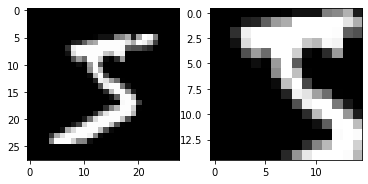

In [6]:
# Plot an image
plt.subplot(1, 2, 1)
plt.imshow(images_array[0][images_array.schema.attr(0).name], cmap="gray")

# Plot part of the same image
plt.subplot(1, 2, 2)
plt.imshow(images_array[0, 5:20, 5:20][images_array.schema.attr(0).name], cmap="gray")

We can then define a function that creates a basic digit classifier for the MNIST dataset.

In [7]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10)
    ])

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer='adam',
                  loss=loss_fn,
                  metrics=['accuracy'])

    return model

Now we move on with creating a model, opening the arrays, define a Tensorflow TileDB dataset and train the model.

In [8]:
from tiledb.ml.readers.tensorflow import TensorflowTileDBDataset, ArrayParams

model = create_model()

ctx = tiledb.Ctx({'sm.memory_budget': 1024**2})
with tiledb.open(training_images, ctx=ctx) as x, tiledb.open(training_labels, ctx=ctx) as y:
    tiledb_dataset = TensorflowTileDBDataset(
        ArrayParams(array=x, fields=['features']),
        ArrayParams(array=y, fields=['features']),
        num_workers=2 if os.cpu_count() > 2 else 0,
    )
    tiledb_dataset = tiledb_dataset.batch(64).shuffle(128)
    model.fit(tiledb_dataset, epochs=5)

2022-08-10 16:27:34.953803: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
938/938 [==============================] - 5s 4ms/step - loss: 0.3426 - accuracy: 0.9022
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1658 - accuracy: 0.9510
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1239 - accuracy: 0.9632
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1015 - accuracy: 0.9688
Epoch 5/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0866 - accuracy: 0.9732


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
